Dataset shape after removing 0 prices: (1490, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 1490 entries, 17 to 4599
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          1490 non-null   float64
 1   bedrooms       1490 non-null   int64  
 2   bathrooms      1490 non-null   float64
 3   sqft_living    1490 non-null   int64  
 4   sqft_lot       1490 non-null   int64  
 5   floors         1490 non-null   float64
 6   waterfront     1490 non-null   int64  
 7   view           1490 non-null   int64  
 8   condition      1490 non-null   int64  
 9   sqft_above     1490 non-null   int64  
 10  sqft_basement  1490 non-null   int64  
 11  yr_built       1490 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 151.3 KB


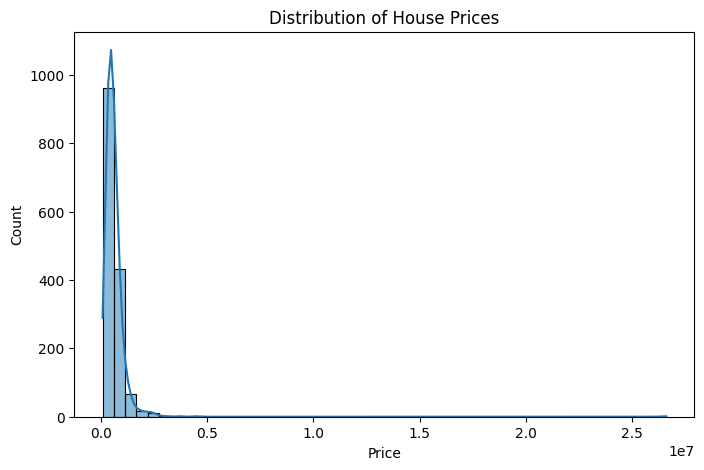

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load housing dataset
data = pd.read_csv("housing.csv")

# Keep houses built between 1990 and 2014
data = data[(data['yr_built'] >= 1990) & (data['yr_built'] <= 2014)]

# Remove invalid price entries (price <= 0)
data = data[data['price'] > 0].copy()

# Display dataset size after filtering
print(f"Dataset shape after removing 0 prices: {data.shape}")

# Show data structure and types
data.info()

# Display basic descriptive statistics
data.describe()

# Plot distribution of house prices
plt.figure(figsize=(8, 5))
sns.histplot(data['price'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

Optimal lambda: 0.14509700595220448


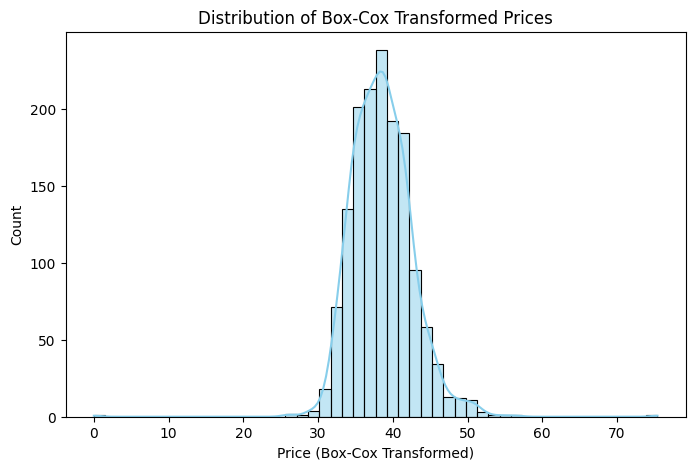

Training set shape: (1192, 11)
Test set shape: (298, 11)


In [ ]:
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Box-Cox transformation to stabilize variance (requires positive values)
y_shifted = data['price'] - data['price'].min() + 1  # ensure all values > 0
y_boxcox, fitted_lambda = boxcox(y_shifted)
print("Optimal lambda:", fitted_lambda)

# Store transformed target in dataset
data['price_boxcox'] = y_boxcox

# Visualize distribution after Box-Cox transformation
plt.figure(figsize=(8, 5))
sns.histplot(data['price_boxcox'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Box-Cox Transformed Prices")
plt.xlabel("Price (Box-Cox Transformed)")
plt.ylabel("Count")
plt.show()

# Select feature columns and target variable
X = data[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
          'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built']]
y = data['price_boxcox']

# Split data into training and testing sets
X_train, X_test, y_train_boxcox, y_test_boxcox = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm final dataset shapes
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

In [ ]:
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# XGBoost: use raw (unscaled) features — model is scale-invariant
X_train_xgb = X_train
X_test_xgb = X_test

# Neural Network: use scaled features — model is scale-sensitive
X_train_nn = X_train_scaled
X_test_nn = X_test_scaled

# Target variables
y_train_target = y_train_boxcox
y_test_target = y_test_boxcox

# ----- Train XGBoost Regressor -----
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train_target)

# XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# ----- Build and Train Neural Network -----
nn_model = Sequential([
    Dense(64, input_dim=X_train_nn.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # linear output for regression
])

# Compile NN with Adam optimizer and MSE loss
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train NN with validation split
history = nn_model.fit(
    X_train_nn, y_train_target,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Neural Network predictions
y_pred_nn = nn_model.predict(X_test_nn).ravel()

# ----- Evaluation -----
def evaluate(y_true, y_pred, label="Model"):
    """Print MAE, RMSE, and R² for given predictions."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Compare model performance
evaluate(y_test_target, y_pred_xgb, "XGBoost")
evaluate(y_test_target, y_pred_nn, "Neural Network")

c:\Users\damai\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1418.7275 - mae: 37.4165 - val_loss: 1321.0659 - val_mae: 36.1320
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1219.8605 - mae: 34.6081 - val_loss: 1047.9202 - val_mae: 32.0464
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 861.9694 - mae: 28.7302 - val_loss: 615.2446 - val_mae: 23.9761
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 428.6418 - mae: 19.0928 - val_loss: 232.4009 - val_mae: 13.6163
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171.8680 - mae: 11.0604 - val_loss: 104.4479 - val_mae: 8.2537
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105.5588 - mae: 7.8798 - val_loss: 76.2331 - val_mae: 6.7265
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.4215 - mae: 6.7185 - val_loss: 61.8706 - val_mae: 5.9728
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66.3790 - mae: 6.0498 - val_loss: 52.8024 - val_mae: 5.5152
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━

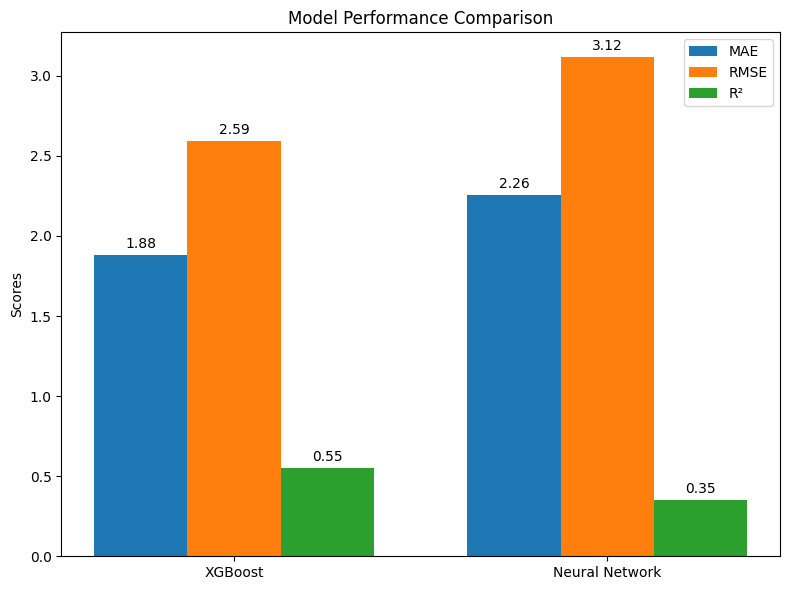

In [ ]:
import matplotlib.pyplot as plt

# ----- Calculate model metrics -----
r2_scores = [
    r2_score(y_test_target, y_pred_xgb),
    r2_score(y_test_target, y_pred_nn)
]

mae_scores = [
    mean_absolute_error(y_test_target, y_pred_xgb),
    mean_absolute_error(y_test_target, y_pred_nn)
]

rmse_scores = [
    np.sqrt(mean_squared_error(y_test_target, y_pred_xgb)),
    np.sqrt(mean_squared_error(y_test_target, y_pred_nn))
]

models = ['XGBoost', 'Neural Network']

# ----- Create comparison bar chart -----
x = np.arange(len(models))   # x-axis label positions
width = 0.25                 # width of each bar

fig, ax = plt.subplots(figsize=(8, 6))

# Plot MAE, RMSE, and R² bars side-by-side
rects1 = ax.bar(x - width, mae_scores, width, label='MAE')
rects2 = ax.bar(x, rmse_scores, width, label='RMSE')
rects3 = ax.bar(x + width, r2_scores, width, label='R²')

# Add axis labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate each bar with its value
def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset above bar
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(rects1)
annotate_bars(rects2)
annotate_bars(rects3)

# Adjust layout and display chart
plt.tight_layout()
plt.show()

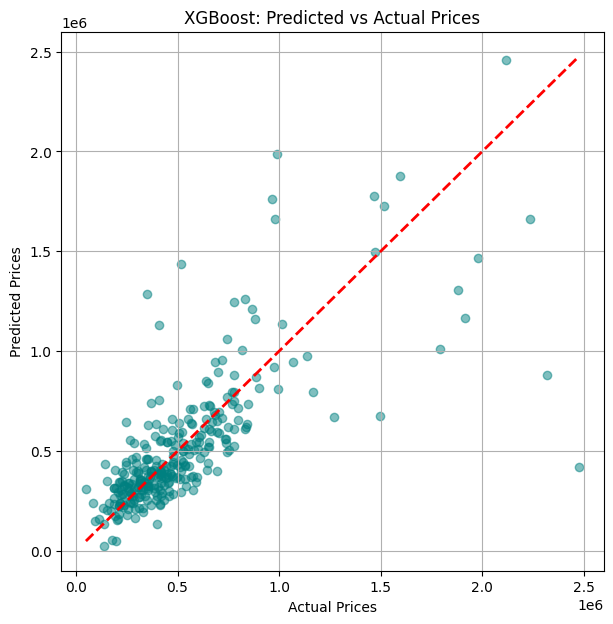

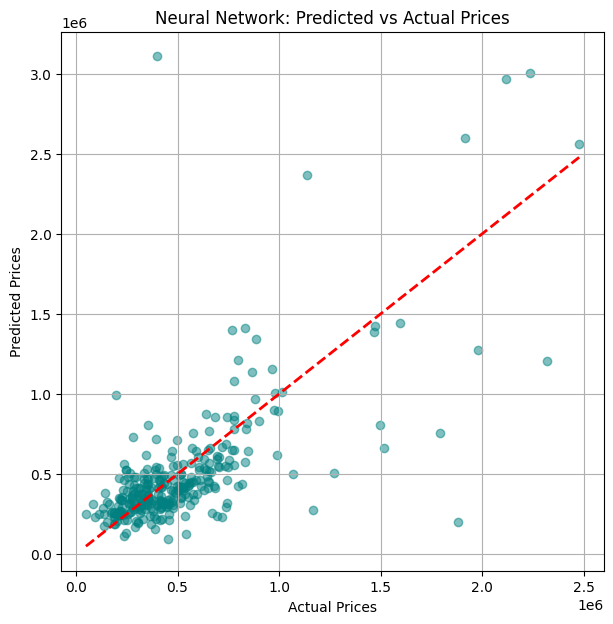

In [ ]:
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# ----- Reverse Box-Cox transformation to original price scale -----
y_pred_xgb_orig = inv_boxcox(y_pred_xgb, fitted_lambda)
y_pred_nn_orig = inv_boxcox(y_pred_nn, fitted_lambda)
y_test_orig = inv_boxcox(y_test_target, fitted_lambda)

# ----- Function: plot predicted vs. actual prices -----
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.5, color='teal')  # predicted vs actual scatter
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        'r--', lw=2  # reference line for perfect predictions
    )
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(title)
    plt.grid(True)
    plt.show()

# ----- Visualize model predictions -----
plot_predicted_vs_actual(y_test_orig, y_pred_xgb_orig, title="XGBoost: Predicted vs Actual Prices")
plot_predicted_vs_actual(y_test_orig, y_pred_nn_orig, title="Neural Network: Predicted vs Actual Prices")

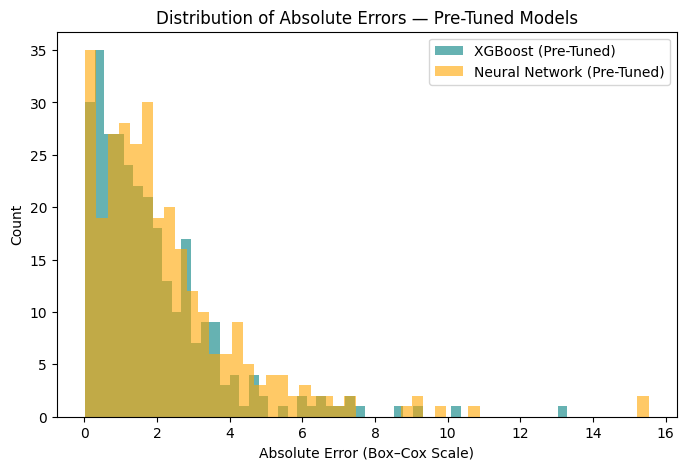

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals and absolute errors
residuals_xgb = y_test_target - y_pred_xgb
residuals_nn = y_test_target - y_pred_nn

abs_error_xgb = np.abs(residuals_xgb)
abs_error_nn = np.abs(residuals_nn)

# Distributions of absolute errors
plt.figure(figsize=(8,5))
plt.hist(abs_error_xgb, bins=50, alpha=0.6, label='XGBoost (Pre-Tuned)', color='teal')
plt.hist(abs_error_nn, bins=50, alpha=0.6, label='Neural Network (Pre-Tuned)', color='orange')
plt.xlabel("Absolute Error (Box–Cox Scale)")
plt.ylabel("Count")
plt.title("Distribution of Absolute Errors — Pre-Tuned Models")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score

# ----- Define hyperparameter search space for XGBoost -----
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Base XGBoost model (before tuning)
xgb_base = XGBRegressor(random_state=42)

# ----- Randomized Search for hyperparameter tuning -----
rscv = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_grid,
    n_iter=20,              # number of random parameter combinations
    scoring=make_scorer(r2_score),
    cv=3,                   # 3-fold cross-validation
    verbose=1,
    n_jobs=-1               # use all available CPU cores
)

# Fit RandomizedSearchCV on training data
rscv.fit(X_train_xgb, y_train_target)

# Display best hyperparameter combination
print("Best params:", rscv.best_params_)

# Predict using the best found model
y_pred_xgb_tuned = rscv.best_estimator_.predict(X_test_xgb)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 1.0, 'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ----- Define model builder for Keras Tuner -----
def build_model(hp):
    model = Sequential()
    # Tune number of hidden layers and neurons per layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', 16, 128, step=16),
            activation='relu'
        ))
    model.add(Dense(1, activation='linear'))  # output layer for regression
    
    # Tune learning rate for Adam optimizer
    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    return model

# ----- Set up Random Search tuner -----
tuner = RandomSearch(
    build_model,
    objective='val_loss',          # minimize validation loss
    max_trials=10,                 # number of hyperparameter combinations
    executions_per_trial=1,        # model training runs per trial
    directory='nn_tuner',
    project_name='housing'
)

# ----- Run hyperparameter search -----
tuner.search(X_train_nn, y_train_target, epochs=50, validation_split=0.2, verbose=1)

# Retrieve best-performing model
best_model = tuner.get_best_models(num_models=1)[0]

# ----- Predict using best tuned Neural Network -----
y_pred_nn_tuned = best_model.predict(X_test_nn).ravel()

C:\Users\damai\AppData\Local\Temp\ipykernel_22152\3267903011.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from nn_tuner\housing\tuner0.json

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


c:\Users\damai\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ----- Evaluation function for model performance -----
def evaluate(y_true, y_pred, label="Model"):
    """Compute and print MAE, RMSE, and R² for given predictions."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

# ----- Compare model performance before and after tuning -----
print("=== Pre-Tuned Models ===")
evaluate(y_test_target, y_pred_xgb, "XGBoost (Pre-Tuned)")
evaluate(y_test_target, y_pred_nn, "Neural Network (Pre-Tuned)")

print("\n=== Post-Tuned Models ===")
evaluate(y_test_target, y_pred_xgb_tuned, "XGBoost (Tuned)")
evaluate(y_test_target, y_pred_nn_tuned, "Neural Network (Tuned)")

=== Pre-Tuned Models ===
XGBoost (Pre-Tuned) - MAE: 1.88, RMSE: 2.59, R²: 0.552
Neural Network (Pre-Tuned) - MAE: 2.26, RMSE: 3.12, R²: 0.353

=== Post-Tuned Models ===
XGBoost (Tuned) - MAE: 1.77, RMSE: 2.41, R²: 0.613
Neural Network (Tuned) - MAE: 1.94, RMSE: 2.64, R²: 0.536


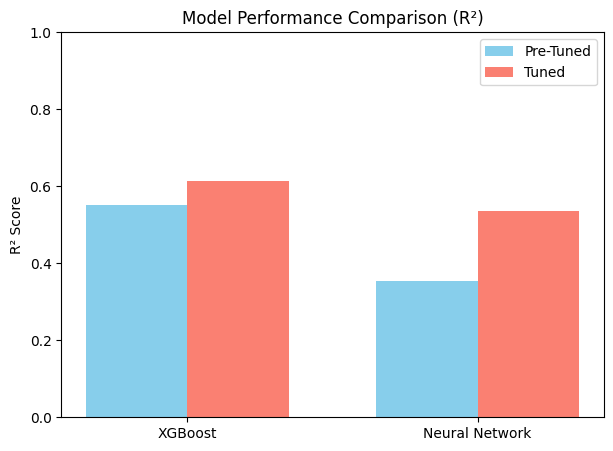

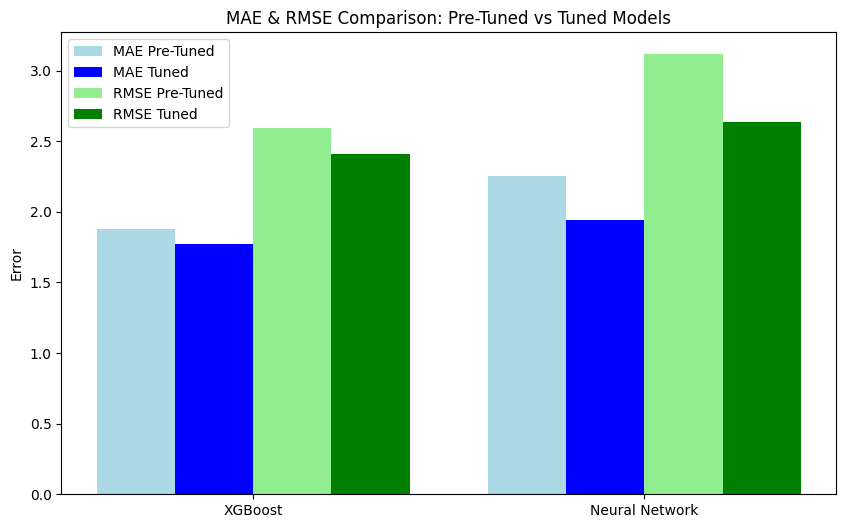

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----- Compute model metrics (R²) for pre-tuned and tuned models -----
r2_pre = [r2_score(y_test_target, y_pred_xgb), r2_score(y_test_target, y_pred_nn)]
r2_post = [r2_score(y_test_target, y_pred_xgb_tuned), r2_score(y_test_target, y_pred_nn_tuned)]

models = ['XGBoost', 'Neural Network']
x = np.arange(len(models))
width = 0.35

# ----- Plot R² scores -----
plt.figure(figsize=(7, 5))
plt.bar(x - width/2, r2_pre, width, label='Pre-Tuned', color='skyblue')
plt.bar(x + width/2, r2_post, width, label='Tuned', color='salmon')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (R²)')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.show()

# ----- Compute MAE and RMSE for pre-tuned and tuned models -----
mae_pre = [mean_absolute_error(y_test_target, y_pred_xgb),
           mean_absolute_error(y_test_target, y_pred_nn)]
mae_post = [mean_absolute_error(y_test_target, y_pred_xgb_tuned),
            mean_absolute_error(y_test_target, y_pred_nn_tuned)]

rmse_pre = [np.sqrt(mean_squared_error(y_test_target, y_pred_xgb)),
            np.sqrt(mean_squared_error(y_test_target, y_pred_nn))]
rmse_post = [np.sqrt(mean_squared_error(y_test_target, y_pred_xgb_tuned)),
             np.sqrt(mean_squared_error(y_test_target, y_pred_nn_tuned))]

x = np.arange(len(models))
width = 0.2

# ----- Plot MAE & RMSE comparison -----
plt.figure(figsize=(10, 6))
plt.bar(x - width, mae_pre, width, label='MAE Pre-Tuned', color='lightblue')
plt.bar(x, mae_post, width, label='MAE Tuned', color='blue')
plt.bar(x + width, rmse_pre, width, label='RMSE Pre-Tuned', color='lightgreen')
plt.bar(x + 2*width, rmse_post, width, label='RMSE Tuned', color='green')

plt.xticks(x + width/2, models)
plt.ylabel("Error")
plt.title("MAE & RMSE Comparison: Pre-Tuned vs Tuned Models")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----- Create average ensemble predictions -----
y_pred_ensemble_boxcox = (y_pred_xgb_tuned + y_pred_nn_tuned) / 2

# ----- Compute metrics (RMSE, MAE, R²) for tuned models and ensemble -----
metrics = {
    "XGBoost (Tuned)": [
        np.sqrt(mean_squared_error(y_test_target, y_pred_xgb_tuned)),
        mean_absolute_error(y_test_target, y_pred_xgb_tuned),
        r2_score(y_test_target, y_pred_xgb_tuned)
    ],
    "Neural Network (Tuned)": [
        np.sqrt(mean_squared_error(y_test_target, y_pred_nn_tuned)),
        mean_absolute_error(y_test_target, y_pred_nn_tuned),
        r2_score(y_test_target, y_pred_nn_tuned)
    ],
    "Ensemble (XGB + NN)": [
        np.sqrt(mean_squared_error(y_test_target, y_pred_ensemble_boxcox)),
        mean_absolute_error(y_test_target, y_pred_ensemble_boxcox),
        r2_score(y_test_target, y_pred_ensemble_boxcox)
    ]
}

# ----- Display comparison -----
print("\n=== Post-Tuned vs Ensemble Model ===")
print("Model\t\t\tRMSE\t\tMAE\t\tR²")
for name, (rmse, mae, r2) in metrics.items():
    print(f"{name:25s}{rmse:.4f}\t\t{mae:.4f}\t\t{r2:.4f}")


=== Post-Tuned vs Ensemble Model ===
Model			RMSE		MAE		R²
XGBoost (Tuned)          2.4095		1.7745		0.6133
Neural Network (Tuned)   2.6385		1.9390		0.5363
Ensemble (XGB + NN)      2.3132		1.7554		0.6436


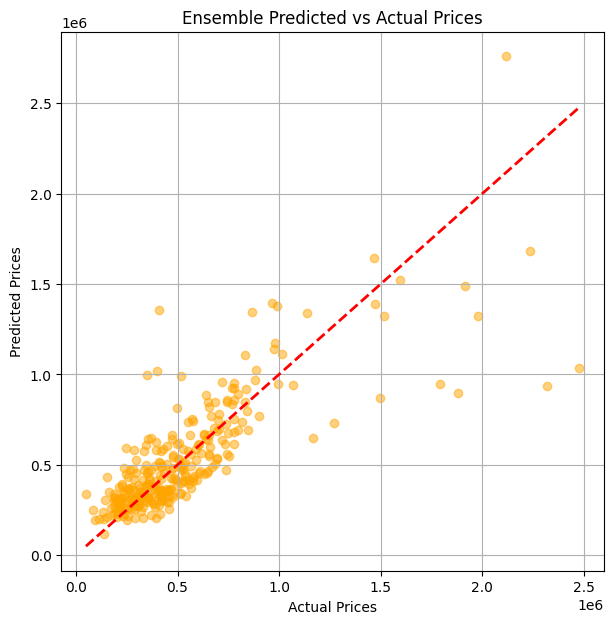

In [ ]:
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# ----- Invert Box-Cox transformation to original price scale -----
y_test_orig = inv_boxcox(y_test_target, fitted_lambda)
y_pred_ensemble_orig = inv_boxcox(y_pred_ensemble_boxcox, fitted_lambda)

# ----- Function to plot predicted vs actual prices -----
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.5, color='orange')  # scatter plot of predictions
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        'r--', lw=2  # reference line for perfect predictions
    )
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(title)
    plt.grid(True)
    plt.show()

# ----- Visualize ensemble model predictions -----
plot_predicted_vs_actual(y_test_orig, y_pred_ensemble_orig, "Ensemble Predicted vs Actual Prices")

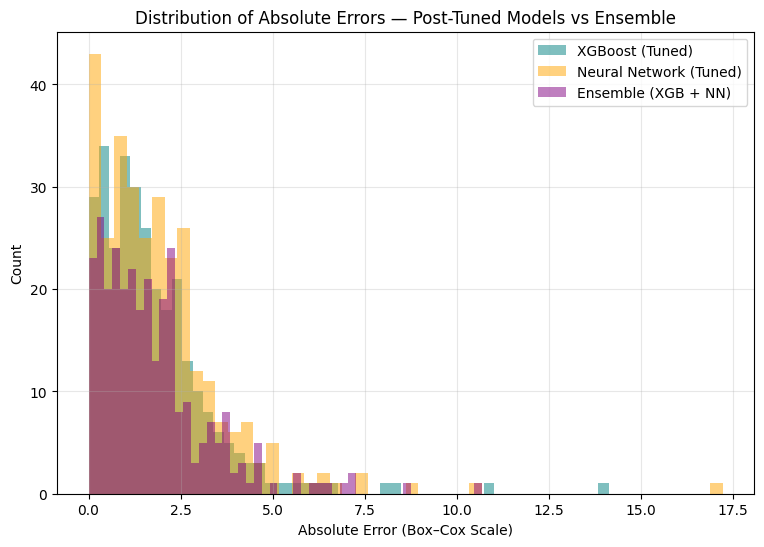

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Compute residuals and absolute errors -----
residuals_xgb_tuned = y_test_target - y_pred_xgb_tuned
residuals_nn_tuned = y_test_target - y_pred_nn_tuned
residuals_ensemble = y_test_target - y_pred_ensemble_boxcox

abs_error_xgb_tuned = np.abs(residuals_xgb_tuned)
abs_error_nn_tuned = np.abs(residuals_nn_tuned)
abs_error_ensemble = np.abs(residuals_ensemble)

# ----- Plot distributions of absolute errors -----
plt.figure(figsize=(9, 6))
plt.hist(abs_error_xgb_tuned, bins=50, alpha=0.5, label='XGBoost (Tuned)', color='teal')
plt.hist(abs_error_nn_tuned, bins=50, alpha=0.5, label='Neural Network (Tuned)', color='orange')
plt.hist(abs_error_ensemble, bins=50, alpha=0.5, label='Ensemble (XGB + NN)', color='purple')

plt.xlabel("Absolute Error (Box–Cox Scale)")
plt.ylabel("Count")
plt.title("Distribution of Absolute Errors — Post-Tuned Models vs Ensemble")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

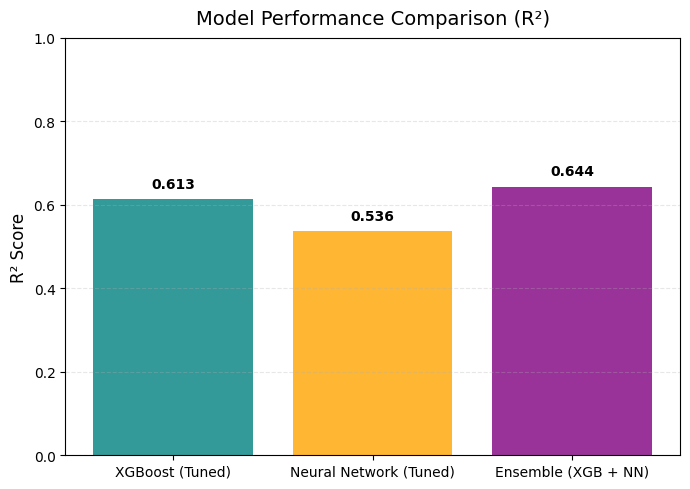

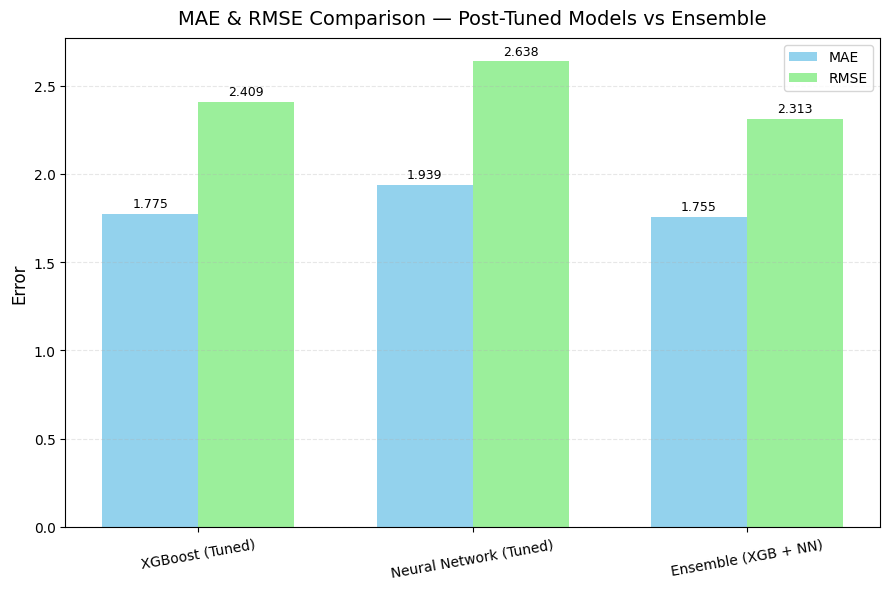

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----- Define models and compute metrics -----
models = ['XGBoost (Tuned)', 'Neural Network (Tuned)', 'Ensemble (XGB + NN)']

r2_scores = [
    r2_score(y_test_target, y_pred_xgb_tuned),
    r2_score(y_test_target, y_pred_nn_tuned),
    r2_score(y_test_target, y_pred_ensemble_boxcox)
]

mae_scores = [
    mean_absolute_error(y_test_target, y_pred_xgb_tuned),
    mean_absolute_error(y_test_target, y_pred_nn_tuned),
    mean_absolute_error(y_test_target, y_pred_ensemble_boxcox)
]

rmse_scores = [
    np.sqrt(mean_squared_error(y_test_target, y_pred_xgb_tuned)),
    np.sqrt(mean_squared_error(y_test_target, y_pred_nn_tuned)),
    np.sqrt(mean_squared_error(y_test_target, y_pred_ensemble_boxcox))
]

# ----- Plot R² scores -----
plt.figure(figsize=(7, 5))
colors = ['teal', 'orange', 'purple']

bars = plt.bar(models, r2_scores, color=colors, alpha=0.8)
plt.ylabel('R² Score', fontsize=12)
plt.title('Model Performance Comparison (R²)', fontsize=14, pad=10)
plt.ylim(0, 1)

# Annotate bars with R² values
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, r2_scores[i] + 0.02,
             f"{r2_scores[i]:.3f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ----- Plot MAE and RMSE side by side -----
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9, 6))
plt.bar(x - width/2, mae_scores, width, label='MAE', color='skyblue', alpha=0.9)
plt.bar(x + width/2, rmse_scores, width, label='RMSE', color='lightgreen', alpha=0.9)

plt.xticks(x, models, rotation=10)
plt.ylabel("Error", fontsize=12)
plt.title("MAE & RMSE Comparison — Post-Tuned Models vs Ensemble", fontsize=14, pad=10)
plt.legend()

# Annotate bars with numeric values
for i in range(len(models)):
    plt.text(x[i] - width/2, mae_scores[i] + 0.02, f"{mae_scores[i]:.3f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, rmse_scores[i] + 0.02, f"{rmse_scores[i]:.3f}", ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

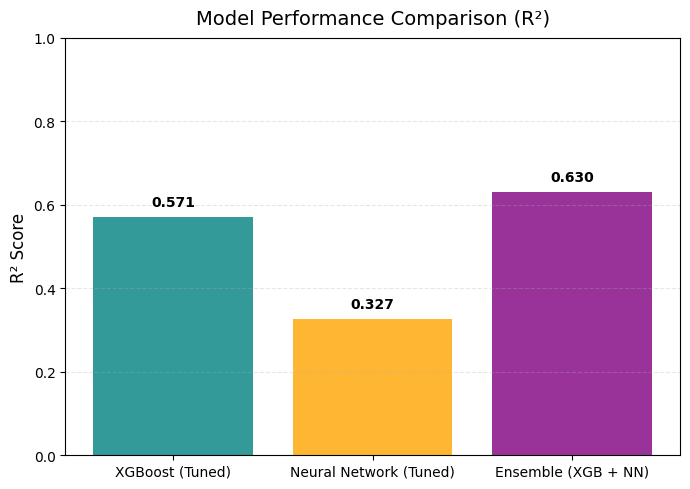

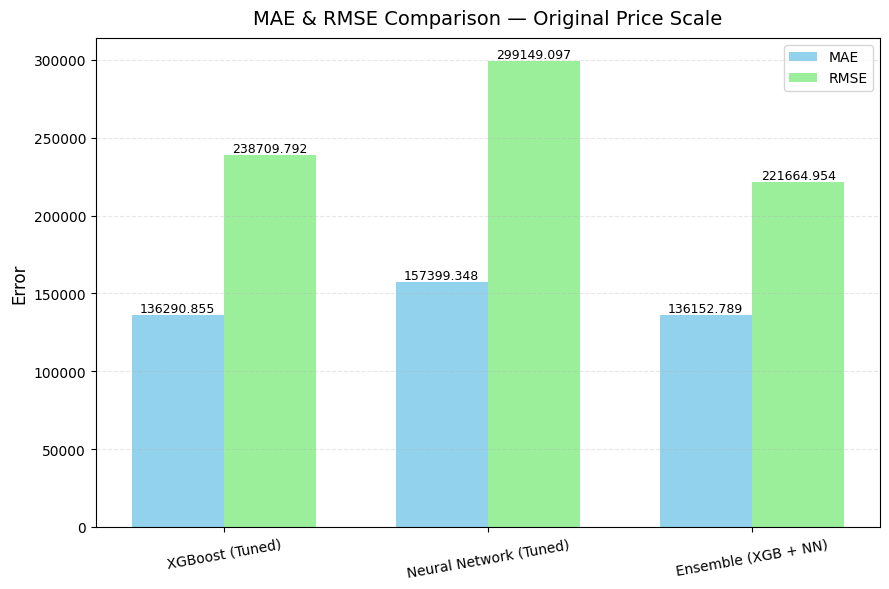


================ MODEL PERFORMANCE SUMMARY (Original Price Scale) ================

XGBoost (Tuned):
  R² Score: 0.5712
  MAE:      136290.8547
  RMSE:     238709.7922

Neural Network (Tuned):
  R² Score: 0.3266
  MAE:      157399.3477
  RMSE:     299149.0970

Ensemble (XGB + NN):
  R² Score: 0.6303
  MAE:      136152.7893
  RMSE:     221664.9542




In [ ]:
from scipy.special import inv_boxcox

# ----- Undo Box–Cox -----
y_test_shifted = inv_boxcox(y_test_target, fitted_lambda)
y_pred_xgb_shifted = inv_boxcox(y_pred_xgb_tuned, fitted_lambda)
y_pred_nn_shifted = inv_boxcox(y_pred_nn_tuned, fitted_lambda)
y_pred_ensemble_shifted = inv_boxcox(y_pred_ensemble_boxcox, fitted_lambda)

# ----- Undo price shift (original: y_shifted = price - price_min + 1) ----- 
price_min = data['price'].min()

y_test_original = y_test_shifted + price_min - 1
y_pred_xgb = y_pred_xgb_shifted + price_min - 1
y_pred_nn = y_pred_nn_shifted + price_min - 1
y_pred_ensemble = y_pred_ensemble_shifted + price_min - 1


# ----- Recompute metrics on original scale ----- 
models = ['XGBoost (Tuned)', 'Neural Network (Tuned)', 'Ensemble (XGB + NN)']

r2_scores = [
    r2_score(y_test_original, y_pred_xgb),
    r2_score(y_test_original, y_pred_nn),
    r2_score(y_test_original, y_pred_ensemble)
]

mae_scores = [
    mean_absolute_error(y_test_original, y_pred_xgb),
    mean_absolute_error(y_test_original, y_pred_nn),
    mean_absolute_error(y_test_original, y_pred_ensemble)
]

rmse_scores = [
    np.sqrt(mean_squared_error(y_test_original, y_pred_xgb)),
    np.sqrt(mean_squared_error(y_test_original, y_pred_nn)),
    np.sqrt(mean_squared_error(y_test_original, y_pred_ensemble))
]


# ----- Plot R² bar chart ----- 
plt.figure(figsize=(7,5))
colors = ['teal', 'orange', 'purple']

bars = plt.bar(models, r2_scores, color=colors, alpha=0.8)
plt.ylabel('R² Score', fontsize=12)
plt.title('Model Performance Comparison (R²)', fontsize=14, pad=10)
plt.ylim(0, 1)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, r2_scores[i] + 0.02,
             f"{r2_scores[i]:.3f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


# ----- Plot MAE & RMSE bar chart ----- 
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,6))
plt.bar(x - width/2, mae_scores, width, label='MAE', color='skyblue', alpha=0.9)
plt.bar(x + width/2, rmse_scores, width, label='RMSE', color='lightgreen', alpha=0.9)

plt.xticks(x, models, rotation=10)
plt.ylabel("Error", fontsize=12)
plt.title("MAE & RMSE Comparison — Original Price Scale", fontsize=14, pad=10)
plt.legend()

for i in range(len(models)):
    plt.text(x[i] - width/2, mae_scores[i] + 0.02, f"{mae_scores[i]:.3f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, rmse_scores[i] + 0.02, f"{rmse_scores[i]:.3f}", ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
